In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
# Converts LTSpice to df

def ltspice_to_df(filepath: str) -> pd.DataFrame:
    """
    Converts an LTspice-exported text file to a clean pandas DataFrame.
    Works for any standard LTspice export (tab or space separated).

    Example:
    --------
    df = ltspice_to_df("export.txt")
    print(df.head())
    df.plot(x=df.columns[0], y=df.columns[1:])
    """
    df = pd.read_csv(filepath, delim_whitespace=True, comment='#')
    return df

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# ---------- helpers ----------
def _nice_step(raw_step: float) -> float:
    """Round a step to a 'nice' 1–2–2.5–5–10 × 10^n."""
    if raw_step <= 0 or not np.isfinite(raw_step):
        return 1.0
    exp  = np.floor(np.log10(raw_step))
    frac = raw_step / (10**exp)
    for m in (1, 2, 2.5, 5, 10):
        if frac <= m:
            return m * (10**exp)
    return 10**(exp + 1)

def label_every_grid(ax, target_major_ticks: int = 25) -> None:
    """Label every grid line with adaptive 'nice' major ticks on both axes."""
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xstep = _nice_step((xmax - xmin) / max(target_major_ticks, 2))
    ystep = _nice_step((ymax - ymin) / max(target_major_ticks, 2))
    ax.xaxis.set_major_locator(MultipleLocator(xstep))
    ax.yaxis.set_major_locator(MultipleLocator(ystep))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.grid(True, which='major', linestyle='--', alpha=0.6)

# ---------- generic family-of-curves plotter for MOSFET (or anything) ----------
def plot_family_curves(
    title: str,
    x_label: str,
    y_label: str,
    df: pd.DataFrame,
    group_col: str,      # e.g., 'vgg' (VGS)
    x_col: str,          # e.g., 'vds'
    y_col: str,          # e.g., 'irg' (ID in A)
    *,
    y_scale: float = 1.0,          # e.g., 1000 for mA
    annotate_on_curves: bool = True,
    target_major_ticks: int = 30,
    marker: str = 'o',
    markersize: float = 3,
    linewidth: float = 1.8,
    every_other_xtick: bool = True,   # <— new option
):
    """
    Plot a family of curves (y vs x) grouped by `group_col`.

    Requires helper: label_every_grid(ax, target_major_ticks)
    """
    data = df.copy()
    for c in [group_col, x_col, y_col]:
        data[c] = pd.to_numeric(data[c], errors='coerce')
    data = data.dropna(subset=[group_col, x_col, y_col]).sort_values([group_col, x_col])

    data['_yplot'] = data[y_col] * y_scale

    fig, ax = plt.subplots(figsize=(8, 6))

    for gval, g in data.groupby(group_col, sort=True):
        x = g[x_col].to_numpy()
        y = g['_yplot'].to_numpy()
        label = f"{group_col.upper()} = {gval:g} V"
        ax.plot(x, y, marker=marker, markersize=markersize, linewidth=linewidth, label=label)
        if annotate_on_curves and len(x):
            ax.text(x[-1], y[-1], f"  {label}", va='center')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    ax.grid(True, which='both', linestyle=':', alpha=0.25)
    label_every_grid(ax, target_major_ticks=target_major_ticks)

    # show every other x tick (after limits are finalized)
    if every_other_xtick:
        xt = ax.get_xticks()
        yt = ax.get_yticks()
        if len(xt) > 2:
            ax.set_xticks(xt[::2])
        if len(yt) > 2:
            ax.set_yticks(yt[::2])

    if not annotate_on_curves:
        ax.legend(fontsize=10)

    fig.tight_layout()
    plt.show()

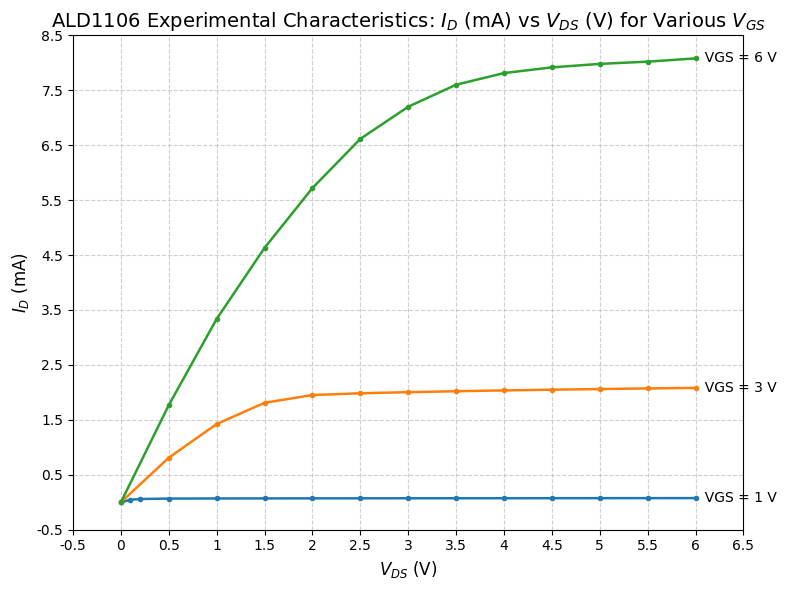

In [4]:
# Plotting experimental NMOS characteristics

title  = r"ALD1106 Experimental Characteristics: $I_D$ (mA) vs $V_{DS}$ (V) for Various $V_{GS}$"
x_ax   = r"$V_{DS}$ (V)"
y_ax   = r"$I_D$ (mA)"

# Group by VGS stored in 'vgg'; plot ID ('irg') vs VDS ('vds'), scale A→mA
df = pd.read_csv('nmos/nmos_id_vgs_exp.csv')
plot_family_curves(title, x_ax, y_ax, df, group_col='vgs', x_col='vds', y_col='irg', y_scale=1000.0)

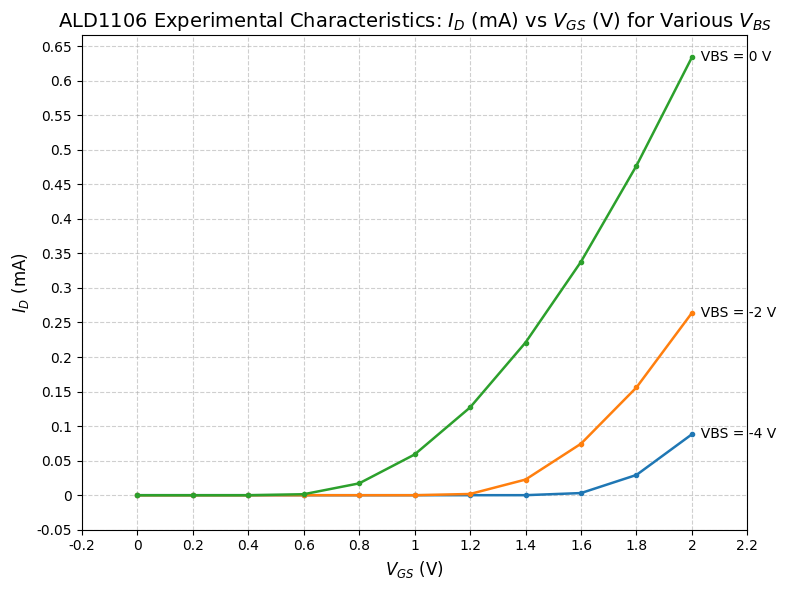

In [5]:
# Plotting experimental NMOS vbs characteristics

title  = r"ALD1106 Experimental Characteristics: $I_D$ (mA) vs $V_{GS}$ (V) for Various $V_{BS}$"
x_ax   = r"$V_{GS}$ (V)"
y_ax   = r"$I_D$ (mA)"

# Group by VGS stored in 'vgg'; plot ID ('irg') vs VDS ('vds'), scale A→mA
df = pd.read_csv('nmos/nmos_id_vbs_exp.csv')
plot_family_curves(title, x_ax, y_ax, df, group_col='vbs', x_col='vgs', y_col='irg', y_scale=1000.0)

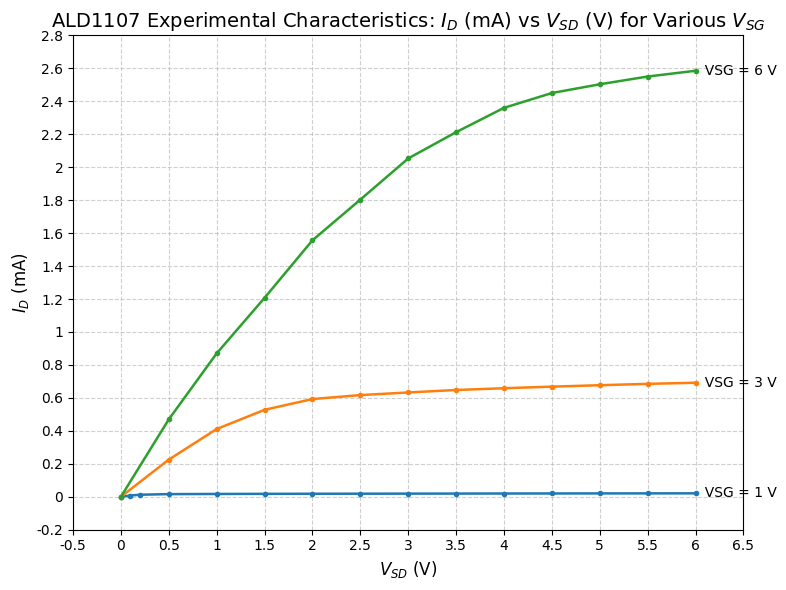

In [6]:
# Plotting experimental NMOS characteristics

title  = r"ALD1107 Experimental Characteristics: $I_D$ (mA) vs $V_{SD}$ (V) for Various $V_{SG}$"
x_ax   = r"$V_{SD}$ (V)"
y_ax   = r"$I_D$ (mA)"

# Group by VGS stored in 'vgg'; plot ID ('irg') vs VDS ('vds'), scale A→mA
df = pd.read_csv('pmos/pmos_id_vsg_exp.csv')
plot_family_curves(title, x_ax, y_ax, df, group_col='vsg', x_col='vsd', y_col='irg', y_scale=1000.0)

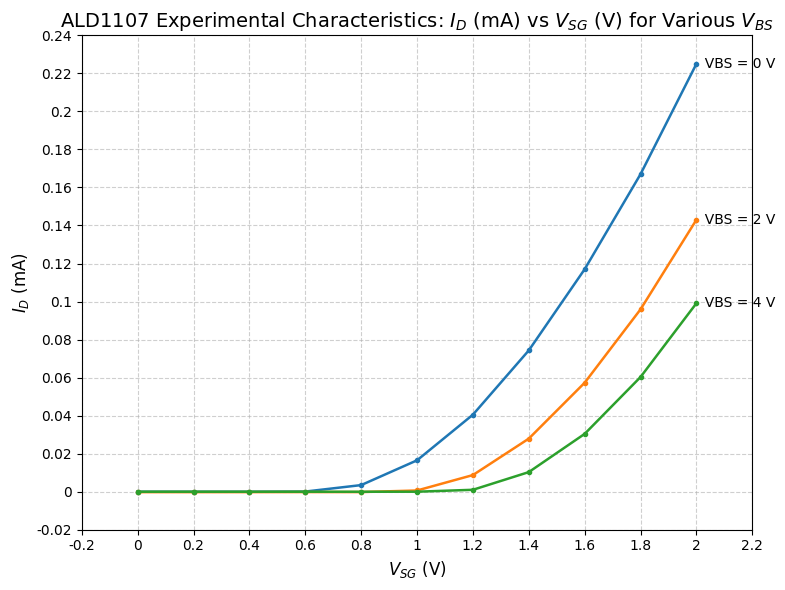

In [7]:
# Plotting experimental PMOS vbs characteristics

title  = r"ALD1107 Experimental Characteristics: $I_D$ (mA) vs $V_{SG}$ (V) for Various $V_{BS}$"
x_ax   = r"$V_{SG}$ (V)"
y_ax   = r"$I_D$ (mA)"

# Group by VGS stored in 'vgg'; plot ID ('irg') vs VDS ('vds'), scale A→mA
df = pd.read_csv('pmos/pmos_id_vbs_exp.csv')
plot_family_curves(title, x_ax, y_ax, df, group_col='vbs', x_col='vsg', y_col='irg', y_scale=1000.0)